In [57]:
import copy
import math
import os
import pickle

import gensim
import lucem_illud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.manifold
from ksvd import ApproximateKSVD
from tqdm import tqdm

%matplotlib inline
tqdm.pandas()

### Constants and Utility Functions

In [75]:
# Constants
MAX_CHAR_LEN = 5000000

In [92]:
# Utility Functions


def coloring(series: pd.Series):
    x = series.values
    y = x - x.min()
    z = y / y.max()
    colors = list(plt.cm.rainbow(z))
    return colors


def plot_dimension(axis, df: pd.DataFrame, dim):
    axis.set_frame_on(False)
    axis.set_title(dim, fontsize=20)
    colors = coloring(df[dim])
    for idx, df_word in enumerate(df.index):
        axis.annotate(
            df_word, (0, df[dim][i]), color=colors[idx], alpha=0.6, fontsize=12
        )
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY, MaxY)
    plt.yticks(())
    plt.xticks(())


def calc_syn0norm(mdl):
    """since syn0norm is now deprecated"""
    return (mdl.wv.syn0 / np.sqrt((mdl.wv.syn0**2).sum(-1))[..., np.newaxis]).astype(
        np.float32
    )


def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(
        base_embed, other_embed, words=words
    )

    # get the embedding matrices
    # base_vecs = calc_syn0norm(in_base_embed)
    # other_vecs = calc_syn0norm(in_other_embed)
    base_vecs = [
        in_base_embed.wv.get_vector(w, norm=True)
        for w in set(in_base_embed.wv.index_to_key)
    ]
    other_vecs = [
        in_other_embed.wv.get_vector(w, norm=True)
        for w in set(in_other_embed.wv.index_to_key)
    ]

    # just a matrix dot product with numpy
    m = np.array(other_vecs).T.dot(np.array(base_vecs))
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors = (np.array(other_vecs)).dot(ortho)
    return other_embed


def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words:
        common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return m1, m2

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(
        key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"),
        reverse=True,
    )

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        new_arr = [m.wv.get_vector(w, norm=True) for w in common_vocab]

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        # old_vocab = m.wv.index_to_key
        new_vocab = []
        k2i = {}
        for new_index, word in enumerate(common_vocab):
            new_vocab.append(word)
            k2i[word] = new_index
        m.wv.index_to_key = new_vocab
        m.wv.key_to_index = k2i
        m.wv.vectors = np.array(new_arr)

    return m1, m2


def raw_models(df, category, text_column_name="normalized_sentences"):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        # This can take a while
        print("Embedding {}".format(cat), end="\r")
        subsetDF = df[df[category] == cat]
        # You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(
            subsetDF[text_column_name].sum()
        )
    return embeddings_raw


def compare_models(
    df,
    category,
    text_column_name="normalized_sentences",
    embeddings_raw=None,
):
    """If you are using time as your category sorting is important"""
    if embeddings_raw is None:
        embeddings_raw = {}
    if len(embeddings_raw) == 0:
        embeddings_raw = raw_models(df, category, text_column_name)
    cats = sorted(set(df[category]))
    # These are much quicker
    embeddings_aligned = {}
    for cat_outer in cats:
        embeddings_aligned[cat_outer] = [embeddings_raw[cat_outer]]
        for cat_inner in cats:
            embeddings_aligned[cat_outer].append(
                smart_procrustes_align_gensim(
                    embeddings_aligned[cat_outer][-1], embeddings_raw[cat_inner]
                )
            )
    return embeddings_raw, embeddings_aligned


def get_divergence_df(emb_word, embeddings_dict):
    cats = sorted(set(embeddings_dict.keys()))
    dists = {}
    print(emb_word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddings_dict[cat][1:]:
            dists[cat].append(
                np.abs(
                    1
                    - sklearn.metrics.pairwise.cosine_similarity(
                        np.expand_dims(embeddings_dict[cat][0].wv[emb_word], axis=0),
                        np.expand_dims(embed.wv[emb_word], axis=0),
                    )[0, 0]
                )
            )
    return pd.DataFrame(dists, index=cats)


def do_aksvd(
    w2v_model,
    n_comp,
    n_non_zeros,
    save=False,
    save_location="data/content/aksvd_models/",
):
    # https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms
    aksvd_t = ApproximateKSVD(
        n_components=n_comp, transform_n_nonzero_coefs=n_non_zeros
    )  # also may adjust n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(
        w2v_model.wv.vectors
    ).components_  # Dictionary is the matrix of discourse atoms.
    alpha_t = aksvd_t.transform(
        w2v_model.wv.vectors
    )  # get the alphas, which are the "weights" of each word on a discourse atoms

    if save:
        outfile = open(
            str(save_location)
            + "200d_"
            + str(n_comp)
            + "comp"
            + str(n_non_zeros)
            + "nonzeros_aksvd_nvdrsdf20",
            "wb",
        )
        pickle.dump(aksvd_t, outfile)
        outfile.close()

        outfile = open(
            str(save_location)
            + "200d_"
            + str(n_comp)
            + "comp"
            + str(n_non_zeros)
            + "nonzeros_dictionary_nvdrsdf20",
            "wb",
        )
        pickle.dump(dictionary_t, outfile)
        outfile.close()

        outfile = open(
            str(save_location)
            + "200d_"
            + str(n_comp)
            + "comp"
            + str(n_non_zeros)
            + "nonzeros_alpha_nvdrsdf20",
            "wb",
        )
        pickle.dump(alpha_t, outfile)
        outfile.close()
    return dictionary_t, alpha_t


def reconstruct_quality(w2v_model, dictionary_mat, alpha_mat):
    # reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    # e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.
    # reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat)

    # https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    # total VARIANCE in the data: sum of squares
    squares3 = w2v_model.wv.vectors - np.mean(w2v_model.wv.vectors, axis=1).reshape(
        -1, 1
    )
    # sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3 = np.sum(np.square(squares3))

    # https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    # total sum of squared ERRORS/residuals
    e3 = [
        reconstructed[idx] - w2v_model.wv.vectors[idx]
        for idx in range(0, len(w2v_model.wv.vectors))
    ]

    # sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3 = np.sum(np.square(e3))

    # https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error
    # R^2: 1- (SSE / SST )
    r2 = 1 - (sse3 / sst3)

    # compute root mean square error
    root_mean_square_error = math.sqrt(np.mean(np.square(e3)))

    return sse3, root_mean_square_error, r2


def topic_diversity(w2v_model, dictionary_mat, top_n=25):
    # list of list, each inner list includes top N words in that topic
    top_words = []

    # set to number of total topics
    for i_dict in range(0, len(dictionary_mat)):
        # set for top N words
        top_words.extend(
            [
                idx[0]
                for idx in w2v_model.wv.similar_by_vector(
                    dictionary_mat[i_dict], topn=top_n
                )
            ]
        )

    uniquewords = set(top_words)
    diversity = len(uniquewords) / len(top_words)
    return diversity

# <font color="red">*Pitch Your Project*</font>
<font color="red">In the three cells immediately following, describe **WHAT** you are 
planning to analyze for your final project (i.e., texts, contexts and the social game, 
world and actors you intend to learn about through your analysis) (<200 words), **WHY** 
you are going to do it (i.e., why would theory and/or the average person benefit from 
knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate 
it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield 
this insight) (<400 words).

## ***What? (<200 words)***
For our project, Chanteria Milner and I will analyze congressional and Supreme Court 
abortion-related legislation. Particularly for the congressional legislation, we will explore 
all legislation from 1973 until 2024. We sourced this legislation from the congress.gov 
legislation search, where we filtered for any legislation within this period that could 
have become bills and included the following keywords in the bill text or summary: 
'abortion,' 'reproduction,' or 'reproductive health care.' For the SCOTUS abortion 
legislation, we targeted SCOTUS decisions outlined on supreme.justia.com, which provides a 
list of abortion-relevant SCOTUS decisions from 1965-2022. Through this analysis, we 
plan to uncover the ways that the legislative abortion discourse has changed over time and 
the prominent congressional bills that have occurred throughout subsequent pieces of legislation. 
We will supplement this analysis with legislation in its political history by taking 
note of the political affiliations of congress members, SCOTUS justices, and the presidency.

Chanteria Milner: [Link](https://github.com/chanteriam)
Michael Plunkett: [Link](https://github.com/michplunkett)\
Congressional source: [Link](https://www.congress.gov/advanced-search/legislation?congressGroup%5B%5D=0&congresses%5B%5D=118&congresses%5B%5D=117&congresses%5B%5D=116&congresses%5B%5D=115&congresses%5B%5D=114&congresses%5B%5D=113&congresses%5B%5D=112&congresses%5B%5D=111&congresses%5B%5D=110&congresses%5B%5D=109&congresses%5B%5D=108&congresses%5B%5D=107&congresses%5B%5D=106&congresses%5B%5D=105&congresses%5B%5D=104&congresses%5B%5D=103&congresses%5B%5D=102&congresses%5B%5D=101&congresses%5B%5D=100&congresses%5B%5D=99&congresses%5B%5D=98&congresses%5B%5D=97&congresses%5B%5D=96&congresses%5B%5D=95&congresses%5B%5D=94&congresses%5B%5D=93&legislationNumbers=&restrictionType=field&restrictionFields%5B%5D=allBillTitles&restrictionFields%5B%5D=summary&summaryField=billSummary&enterTerms=%22reproductive+health+care%22%2C+%22reproduction%22%2C+%22abortion%22&legislationTypes%5B%5D=hr&legislationTypes%5B%5D=hjres&legislationTypes%5B%5D=s&legislationTypes%5B%5D=sjres&public=true&private=true&chamber=all&actionTerms=&legislativeActionWordVariants=true&dateOfActionOperator=equal&dateOfActionStartDate=&dateOfActionEndDate=&dateOfActionIsOptions=yesterday&dateOfActionToggle=multi&legislativeAction=Any&sponsorState=One&member=&sponsorTypes%5B%5D=sponsor&sponsorTypeBool=OR&dateOfSponsorshipOperator=equal&dateOfSponsorshipStartDate=&dateOfSponsorshipEndDate=&dateOfSponsorshipIsOptions=yesterday&committeeActivity%5B%5D=0&committeeActivity%5B%5D=3&committeeActivity%5B%5D=11&committeeActivity%5B%5D=12&committeeActivity%5B%5D=4&committeeActivity%5B%5D=2&committeeActivity%5B%5D=5&committeeActivity%5B%5D=9&satellite=null&search=&submitted=Submitted)
SCOTUS source: [Link](https://supreme.justia.com/cases-by-topic/abortion-reproductive-rights/)

## ***Why? (<200 words)***
This analysis, in general, will give us an understanding of how abortion discourse has
changed over time, and specifically, what arguments were used in the passing of the 
1973 Roe v. Wade decision--and with it, the assertion of the constitutional right to 
abortion and its eventual reversal in the 2022 Dobbs v. Jackson decision. 
From this, we will be able to uncover what political mechanisms were at play that 
enabled this regression in legislation, and how such significant cases went on to influence 
congressional legislation that followed. The average person will, in general, be able 
to understand how sensitive practices are discussed in the political sphere and what 
aspects in particular are targeted for protection or not. Moreover, this analysis 
will allow individuals who want to write reproductive healthcare legislation to 
understand what arguments are more likely to work over others within certain 
political contexts.

## ***How? (<400 words)***


## <font color="red">*Pitch Your Sample*</font>
<font color="red">In the cell immediately following, describe the rationale behind 
your proposed sample design for your final project. What is the social game, social 
work, or social actors you about whom you are seeking to make inferences? What are 
its virtues with respect to your research questions? What are its limitations? What 
are alternatives? What would be a reasonable path to "scale up" your sample for 
further analysis (i.e., high-profile publication) beyond this class?.

## ***Which words? (<300 words)***
Starting in the early 1970s with the adoption of the Hyde Amendment, the amendment 
that prevented federal funding of abortions through Medicaid, anti-abortion advocates 
have attempted to reverse the Roe decision through a multitude of avenues. These efforts 
eventually culminated in the Dobbs v. Jackson decision in 2022. The elevation of the Dobbs 
v. Jackson case was not something that happened by random chance but instead was the result 
of decades of concerted efforts by anti-abortion advocates, think tanks, and political 
action committees. In our project, we intend to see how the social game of these groups 
probing for judicial vulnerabilities changed over time and the language that made up 
those attempts. The actors in this study are primarily the congressional legislators 
and supreme court justices, whom we will study via their decisions and proposed pieces 
of legislation, respectively. This analysis will give us a direct look into the 
terminology used to overturn Roe in its successful and unsuccessful cases.

Our analysis in this project will undoubtedly give us some valuable insights, but it 
will not allow us to create the entire picture. The sources we are using only capture 
the result of the efforts made by anti-abortion advocates, etc. A more complete design 
of this analysis would take documents from conservative think tanks like the Heritage 
Foundation, Family Research Council, Moral Majority, etc. Taking in documents from 
these organizations and other similarly minded ones would give us insight into the 
documents upstream from the legislative and decision documents we're currently 
assessing. To scale this project up for a high-profile journal, we could get 
documents from those organizations listed and look for similarities between them 
and the documents we're currently examining to see the complete evolution of the 
language from its initial planning to attempts at federal implementation.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents 
related to your final project using at least two different specification of 
`word2vec` and/or `fasttext`, and visualize them each with two separate 
visualization layout specifications (e.g., TSNE, PCA). Then interrogate 
critical word vectors within your corpus in terms of the most similar words, 
analogies, and other additions and subtractions that reveal the structure of 
similarity and difference within your semantic space. What does this pattern 
reveal about the semantic organization of words in your corpora? Which 
estimation and visualization specification generate the most insight and 
appear the most robustly supported and why?

<font color="red">***Stretch***: Explore different vector calculations 
beyond addition and subtraction, such as multiplication, division or some 
other function. What does this exploration reveal about the semantic 
structure of your corpus?

In [61]:
# Load the congressional legislation
congressional_leg_df = pd.read_feather("data/tokenized_congress_legislation.feather")
congressional_leg_df.head()

,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,api_url,text_url,raw_text,cleaned_text,cleaned_summary,kmeans_predictions,fcluster_predictions,tokenized_text,normalized_tokens,reduced_tokens
0,H.R. 2907,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,hr,2907,https://api.congress.gov/v3/bill/118/hr/2907/t...,https://www.congress.gov/118/bills/hr2907/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[time, enforcement, or, protective, considerat...","[publishing, time, enforcement, protective, co...","[enforcement, consideration, specific, affecte..."
1,S. 1297,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,s,1297,https://api.congress.gov/v3/bill/118/s/1297/te...,https://www.congress.gov/118/bills/s1297/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[Murphy, time, Hirono, enforcement, Welch, or,...","[publishing, time, van, enforcement, mrs, prot...","[enforcement, specific, affected, defined, sin..."
2,H.R. 4901,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,hr,4901,https://api.congress.gov/v3/bill/118/hr/4901/t...,https://www.congress.gov/118/bills/hr4901/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, g, Community, throughout, partici...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration..."
3,S. 2544,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,s,2544,https://api.congress.gov/v3/bill/118/s/2544/te...,https://www.congress.gov/118/bills/s2544/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, 2544, g, Community, throughout, p...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration..."
4,H.R. 4147,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Training Act of 2023,NaN,NaN,None,118,hr,4147,https://api.congress.gov/v3/bill/118/hr/4147/t...,https://www.congress.gov/118/bills/hr4147/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,None,0,2,"[g, identification, minority, time, centers, o...","[improve, act, public, pensions, cited, publis...","[improve, establish, number, identification, p..."


In [64]:
# Since the tokenization process takes so much computational power/time, I put it
# in a feather file to avoid the time when re-running this analysis.
legislation_feather_path = "data/fully_tokenized_congress_legislation.feather"
if os.path.isfile(legislation_feather_path):
    congressional_leg_df = pd.read_feather(legislation_feather_path)
else:
    # WARNING: This step takes about 120 minutes, so don't run it unless you need to.
    congressional_leg_df["tokenized_sentences"] = congressional_leg_df[
        "cleaned_text"
    ].progress_apply(
        lambda x: [
            lucem_illud.word_tokenize(s, MAX_LEN=MAX_CHAR_LEN)
            for s in lucem_illud.sent_tokenize(x)
        ]
    )
    congressional_leg_df["normalized_sentences"] = congressional_leg_df[
        "tokenized_sentences"
    ].apply(
        lambda x: [
            lucem_illud.normalizeTokens(s, lemma=False, MAX_LEN=MAX_CHAR_LEN) for s in x
        ]
    )
    congressional_leg_df.to_feather(legislation_feather_path)

In [65]:
# Load saved Word2Vec if it exists
word2vec_file_path = "data/congressional_leg_w2v"
if os.path.isfile(word2vec_file_path):
    congressional_leg_w2v = gensim.models.word2vec.Word2Vec.load(word2vec_file_path)
else:
    congressional_leg_w2v = gensim.models.word2vec.Word2Vec(
        congressional_leg_df["normalized_sentences"].sum(), sg=0
    )
    congressional_leg_w2v.save(word2vec_file_path)

In [66]:
# Going to look at words commonly associated with abortion
congressional_leg_w2v.wv.most_similar(["abortion", "healthcare", "health"])

[('gynecological', 0.5437756180763245),
 ('patients', 0.5378872752189636),
 ('obstetrician', 0.5100891590118408),
 ('obstetrical', 0.5008599162101746),
 ('patient', 0.49554017186164856),
 ('care', 0.48337480425834656),
 ('pediatric', 0.47294947504997253),
 ('osteoporosis', 0.47060659527778625),
 ('prenatal', 0.467769980430603),
 ('postpartum', 0.45360267162323)]

In [67]:
# Selecting the top 50 words from the congressional_leg_w2v dataset
# and getting their respective vectors for further analysis.
num_words = 50
target_words = congressional_leg_w2v.wv.index_to_key[:num_words]
words_sub_matrix = []
for word in target_words:
    words_sub_matrix.append(congressional_leg_w2v.wv[word])
words_sub_matrix = np.array(words_sub_matrix)
words_sub_matrix[:10]

array([[ 7.01243401e-01, -1.98045814e+00,  1.69280827e+00,
         8.64630699e-01,  1.28717864e+00, -5.05317926e-01,
         1.13872695e+00, -2.17121810e-01, -1.38199258e+00,
         1.16776371e+00,  2.82135320e+00,  4.74404097e-01,
        -3.11058462e-01, -1.73494726e-01,  1.05794823e+00,
         1.39646626e+00,  1.01622498e+00, -1.30117428e+00,
        -2.61231840e-01,  9.96614575e-01, -6.59144282e-01,
        -4.11819428e-01,  7.32142508e-01, -1.99674547e-01,
         3.31748748e+00, -2.29842734e+00, -4.37350893e+00,
        -1.30481589e+00, -2.22346663e+00, -1.30300462e+00,
         6.20443821e-01,  1.42162040e-01,  1.34954011e+00,
         2.79951620e+00,  3.97904456e-01,  1.75277984e+00,
         1.36425173e+00, -1.13644588e+00, -8.94096136e-01,
         6.47117555e-01, -1.69223821e+00,  6.92348063e-01,
        -1.36289850e-01,  2.51146340e+00, -6.26908243e-01,
        -1.36617064e+00, -1.78015813e-01,  4.45258665e+00,
        -8.76562536e-01,  1.37046635e+00, -9.68483627e-0

In [95]:
def plot_words(word_decompositions, t_words: [str] = target_words) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(
        word_decompositions[:, 0], word_decompositions[:, 1], alpha=0
    )  # Making the points invisible
    for i, t_word in enumerate(t_words):
        ax.annotate(
            t_word,
            (word_decompositions[:, 0][i], word_decompositions[:, 1][i]),
            size=20 * (num_words - i) / num_words,
        )
    plt.xticks(())
    plt.yticks(())
    plt.show()


# Do word analysis using reduced-PCA and T-SNE
pca_words = sklearn.decomposition.PCA(n_components=num_words).fit(words_sub_matrix)
reduced_pca_words = pca_words.transform(words_sub_matrix)
# T-SNE is theoretically better, but you should experiment
tsne_words = sklearn.manifold.TSNE(n_components=2).fit_transform(reduced_pca_words)

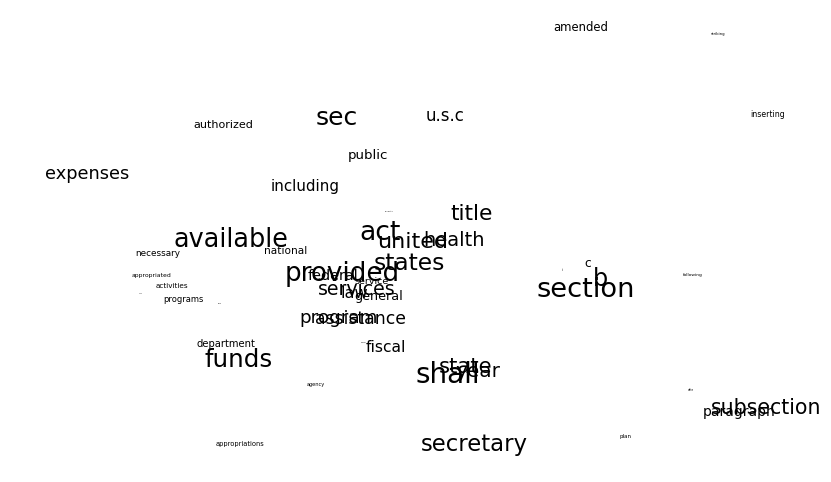

In [97]:
# Create a word cloud of the reduced PCA analysis
plot_words(reduced_pca_words)

The biggest words in the PCA analysis appear to be provided states, available, 
section (c is also there, so I assume it should be c-section), funds, states 
(could be centered around states rights or United States), services, etc. 
This tracks with the assumption that legislation would focus on the availability 
of services, fiscal policy, and states' rights. 

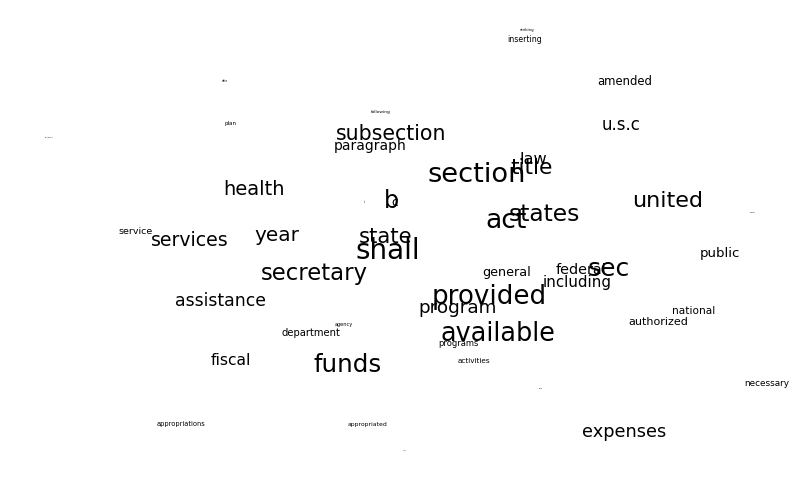

In [99]:
# Create a word cloud of the T-SNE analysis
plot_words(tsne_words)

Similar to the reduced PCA analysis, the T-SNE analysis notes the focus on section (presumably 
'c-section'), funds, states (presumably states rights), funds, expenses, etc. Aside from health
related terms like health, c-section, service, etc. the legislation is more focused on fiscal
policy than anything else. This tracks with our presumption that instead of going for the moving on
the medical aspects of the procedure, anti-abortion legislators would focus on the monetary aspects
of the procedure.

In [70]:
# Do a visualization for PCA, interrogate critical words, look for analogies, what does pattern reveal about corpora, which visual generates the most insight and appears the most robust?

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed 
documents related to your final project using `doc2vec`, and explore 
the relationship between different documents and the word vectors you 
analyzed in the last exercise. Consider the most similar words to 
critical documents, analogies (doc _x_ + word _y_), and other additions 
and subtractions that reveal the structure of similarity and difference 
within your semantic space. What does this pattern reveal about the 
documentary organization of your semantic space?

In [71]:
keywords = ["abortion", "states", "rights", "available", "health", "services", "funds"]
tagged_docs = []
for index, row in congressional_leg_df.iterrows():
    # Simple keyword assignment
    doc_keywords = [s for s in keywords if s in row["normalized_tokens"]]
    doc_keywords.append(row["congress_num"])
    doc_keywords.append(
        row["legislation number"]
    )  # This lets us extract individual documents since legislation numbers are unique
    tagged_docs.append(
        gensim.models.doc2vec.TaggedDocument(
            words=row["normalized_tokens"], tags=doc_keywords
        )
    )
congressional_leg_df["tagged_text"] = tagged_docs

In [72]:
congressional_leg_d2v = gensim.models.doc2vec.Doc2Vec(
    congressional_leg_df["tagged_text"], vector_size=100
)

In [73]:
# Show vector of particular congressional number
congressional_leg_d2v.docvecs[118]

array([ 1.024166  , -0.20583169, -1.4429594 ,  0.17146665,  0.7409893 ,
        1.0770271 ,  0.38801998, -0.08329246, -0.38688505,  0.6865208 ,
        1.8001508 ,  2.144751  ,  2.1954787 ,  1.8553803 ,  1.1894319 ,
       -0.10032054,  3.470067  , -1.4163939 ,  2.7721245 ,  0.17979217,
       -0.00738192, -0.34115425,  2.1106076 , -0.10589121,  1.9208392 ,
       -1.3350208 , -0.03806369,  0.99004227,  0.5167876 , -0.61323005,
        0.16415814,  0.92918867, -2.1281903 ,  0.2835767 ,  1.3110406 ,
       -0.08013124,  2.2212362 , -1.2833102 , -0.61170065, -0.8839472 ,
        2.8279686 ,  1.2331473 ,  1.2649807 ,  0.27686176, -1.3227336 ,
       -1.9213228 ,  1.112054  ,  1.2224151 ,  0.29744366,  1.5467097 ,
        1.4528776 , -0.61406404, -0.24571183, -0.64343673,  0.10095578,
        1.25745   ,  0.29641256, -2.487554  ,  0.45052788,  0.7156666 ,
        0.45203048,  2.0905156 , -1.8694459 , -2.4689262 ,  1.0946468 ,
       -1.8325102 , -1.5583192 , -0.08075324, -0.37497017, -1.41

In [74]:
# Show vector for a particular word
congressional_leg_d2v["abortion"]

array([ 0.7541484 ,  0.03733107,  3.0242984 ,  2.1505616 , -1.7725741 ,
       -2.2004962 , -3.5582895 ,  4.6740766 ,  0.25281116,  3.9081843 ,
        0.97212315,  0.34221327, -0.5010911 ,  4.6811786 ,  0.51785827,
       -3.5600624 ,  1.7469729 ,  0.37162808, -0.7532401 , -2.4794652 ,
       -1.6117945 , -2.6961017 , -0.7729406 ,  1.8959113 , -1.0447681 ,
        4.050584  , -0.94539   ,  2.8589103 , -4.408532  ,  2.239914  ,
        5.2471504 , -1.5874683 ,  1.2941787 , -1.3632458 , -1.2138807 ,
        0.14050528, -1.2585714 , -0.7485317 , -3.3779256 ,  4.919164  ,
       -6.0509677 , -0.32846466, -1.4856358 , -0.04758714, -6.694056  ,
       -6.6925883 , -1.1177745 ,  0.35954565,  0.7809311 ,  2.2587774 ,
       -3.643349  ,  2.0675697 ,  4.338753  ,  2.9292023 ,  3.351528  ,
        2.8669536 ,  0.83603776, -1.082412  ,  1.4627208 ,  1.9026424 ,
        0.48204404, -2.1873329 , -1.4005419 , -1.3464125 ,  3.8452568 ,
        7.0730505 , -0.89328015,  2.9116836 ,  0.2529459 , -2.81

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed 
documents related to your final project, then generate meaningful 
semantic dimensions based on your theoretical understanding of the 
semantic space (i.e., by subtracting semantically opposite word vectors) 
and project another set of word vectors onto those dimensions. Interpret 
the meaning of these projections for your analysis. Which of the dimensions 
you analyze explain the most variation in the projection of your words and why?

<font color="red">***Stretch***: Average together multiple antonym pairs to 
create robust semantic dimensions. How do word projections on these robust 
dimensions differ from single-pair dimensions?

In [83]:
congressional_leg_df.head()

,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,...,cleaned_text,cleaned_summary,kmeans_predictions,fcluster_predictions,tokenized_text,normalized_tokens,reduced_tokens,tokenized_sentences,normalized_sentences,tagged_text
0,H.R. 2907,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,hr,2907,...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[time, enforcement, or, protective, considerat...","[publishing, time, enforcement, protective, co...","[enforcement, consideration, specific, affecte...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([publishing, time, enforcement, protective, c..."
1,S. 1297,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,s,1297,...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[Murphy, time, Hirono, enforcement, Welch, or,...","[publishing, time, van, enforcement, mrs, prot...","[enforcement, specific, affected, defined, sin...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([publishing, time, van, enforcement, mrs, pro..."
2,H.R. 4901,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,hr,4901,...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, g, Community, throughout, partici...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([publishing, experience, g, participating, ti..."
3,S. 2544,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,s,2544,...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, 2544, g, Community, throughout, p...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([publishing, experience, g, participating, ti..."
4,H.R. 4147,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Training Act of 2023,NaN,NaN,None,118,hr,4147,...,Congressional Bills 118th Congress From the U....,None,0,2,"[g, identification, minority, time, centers, o...","[improve, act, public, pensions, cited, publis...","[improve, establish, number, identification, p...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([improve, act, public, pensions, cited, publi..."


In [ ]:
raw_embeddings, compared_embeddings = compare_models(
    congressional_leg_df, category="legislation number"
)

Exception in thread Thread-68 (_worker_loop):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/gensim/models/word2vec.py", line 1166, in _worker_loop
    tally, raw_tally = self._do_train_job(data_iterable, alpha, thread_private_mem)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/michaelp/Documents/GitHub/computation

In [90]:
raw_embeddings.keys()

NameError: name 'raw_embeddings' is not defined

## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that align 
word embeddings over time or across domains/corpora. Interrogate the 
spaces that result and ask which words changed most and least over the 
entire period or between contexts/corpora. What does this reveal about 
the social game underlying your space?